In [7]:
from itertools import chain
from pathlib import Path

import numpy as np
import pandas as pd

from calibration.data import get_passband, castelli_kurucz_locus
from calibration.syn_mag import syn_mag

In [8]:
output_dir = Path('locus')
output_dir.mkdir(exist_ok=True)

In [9]:
PS1_BANDS = 'grizy'
DES_BANDS = 'ugrizY'

survey_bands = {
    'PS1': [(b, f'PAN-STARRS/PS1.{b}') for b in PS1_BANDS],
    'DES': [(b.lower(), f'CTIO/DECam.{b}') for b in DES_BANDS],
    'Gaia': [(name, f'GAIA/GAIA3.{b}') for name, b in [('G', 'G'), ('BP', 'Gbp'), ('RP', 'Grp')]],
}

survey_colors = {
    'PS1': list(zip(PS1_BANDS[:-1], PS1_BANDS[1:])),
    'DES': list(zip(DES_BANDS.lower()[:-1], DES_BANDS.lower()[1:])),
    'Gaia': [('G', 'RP'), ('BP', 'G')],
}

survey_support_color = {
    'PS1': ('r', 'i'),
    'DES': ('r', 'i'),
    'Gaia': ('BP', 'G'),
}

survey_support_color_name = {k: f'{v[0]}_{v[1]}' for k, v in survey_support_color.items()}

metalicity = [-0.5, 0.0]

In [10]:
seds_metalicity = {fe_h: castelli_kurucz_locus(fe_h) for fe_h in metalicity}
seds = list(chain.from_iterable(seds_metalicity.values()))

for survey, bands in survey_bands.items():
    filename = f'locus_{survey}.csv'
    colors = {}
    mags = {name: np.array([syn_mag(sed, band) for sed in seds]) for name, band in bands}
    for blue_band, red_band in survey_colors[survey]:
        color_name = f'{blue_band}_{red_band}'
        color = mags[blue_band] - mags[red_band]
        colors.setdefault(color_name, []).extend(color)
    df = pd.DataFrame(colors)
    df.to_csv(output_dir / filename, index=True, index_label='id')

In [11]:
from scipy.spatial import KDTree

mul_coef = 1.5
add_coef = 0.02

for survey in survey_bands:
    filepath = output_dir / f'locus_{survey}.csv'
    df = pd.read_csv(filepath, index_col='id')
    tree = KDTree(df.values, leafsize=1, copy_data=True)
    distances, indexes = tree.query(df.values, k=2)
    distances, indexes = distances[:, 1], indexes[:, 1]
    per_coord_distance = np.abs(df.values - df.values[indexes])
    min_rectangle = np.max(per_coord_distance, axis=0)
    print(survey)
    print({column: f'{round(diff * mul_coef + add_coef, 2)}' for column, diff in zip(df.columns, min_rectangle)})

PS1
{'g_r': '0.23', 'r_i': '0.3', 'i_z': '0.11', 'z_y': '0.1'}
DES
{'u_g': '0.43', 'g_r': '0.34', 'r_i': '0.33', 'i_z': '0.16', 'z_y': '0.07'}
Gaia
{'G_RP': '0.08', 'BP_G': '0.21'}


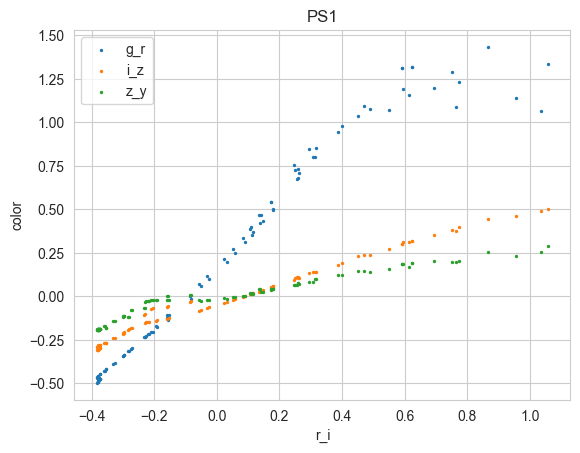

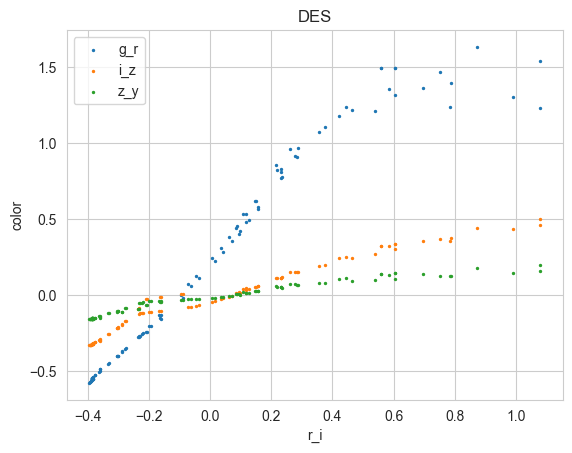

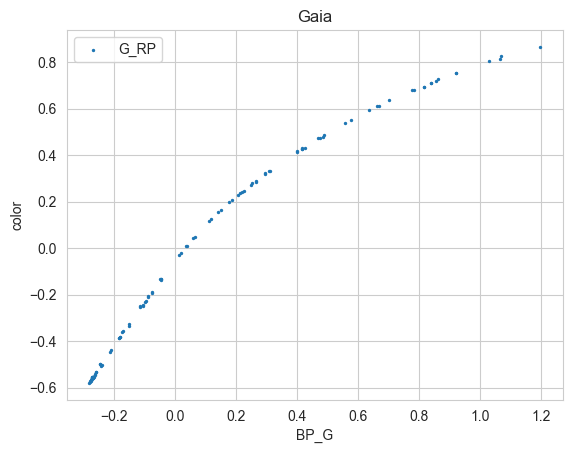

In [12]:
import matplotlib.pyplot as plt

for survey in survey_bands:
    support_color = survey_support_color_name[survey]
    filepath = output_dir / f'locus_{survey}.csv'
    df = pd.read_csv(filepath, index_col='id')
    plt.figure()
    plt.title(survey)
    for column in df.columns:
        if column == 'u_g':
            continue
        if column == support_color:
            continue
        plt.scatter(df[support_color], df[column], label=column, s=2)
    plt.legend()
    plt.xlabel(support_color)
    plt.ylabel('color')